In [1]:
import numpy
import scipy


from metricdiversity.acquisitions.expected_metric_coverage import ExpectedMetricCoverage
from metricdiversity.model.domain import TensorProductDomain
from metricdiversity.model.multi_gaussian_process import MultiOutputGP
from metricdiversity.model.vectorized_optimizer import DEOptimizer

from metricdiversity.utilities.sigopt_colors import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define objective 
def f_1(x, scale_x=1):
  return numpy.exp(-0.5* ((x[0]-0.2)**2 + scale_x * (x[1]-0.5)**2))

def f_2(x, scale_y=1):
  return numpy.exp(-0.5* ((x[0]-0.8)**2 + scale_y *(x[1]-0.5)**2))

def two_humps_unscaled(x):
  return [f_1(x), f_2(x)]

def two_humps_scaled(x):
  return [f_1(x, 4), f_2(x, 4)]

In [3]:
dim = 2
num_pts = 100

domain = TensorProductDomain([[0, 1]] * dim)
random_points = domain.generate_quasi_random_points_in_domain(num_pts)
ys = numpy.zeros((num_pts, dim))
for i, pt in enumerate(random_points):
  ys[i] = two_humps_unscaled(pt)

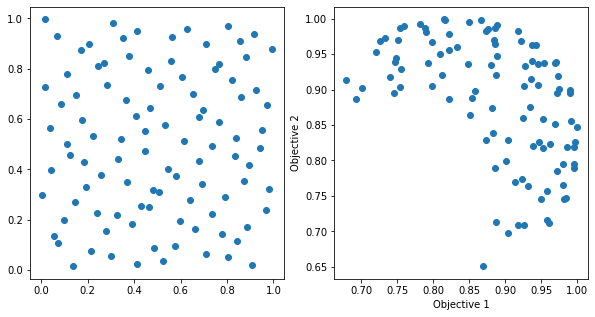

In [4]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

axes[0].scatter(random_points[:, 0], random_points[:, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].scatter(ys[:, 0], ys[:, 1])



In [5]:
initial_points = numpy.array([
  [0.78, 0.44],
  [0.41, 0.79],
  [0.74, 0.92],
  [0.47, 0.12],
  [0.90, 0.64],
  [0.17, 0.33],
])
initial_ys = numpy.zeros((len(initial_points), dim))
for i, pt in enumerate(initial_points):
  initial_ys[i] = two_humps_unscaled(pt)

In [6]:
ub = [1e10, 1e10]
lb = [0.85, 0.85]
punchout_radius = 0.03

gpm = MultiOutputGP(initial_points, initial_ys)
emc = ExpectedMetricCoverage(gpm, ub, lb, punchout_radius)


grid_points = domain.generate_grid_points_in_domain(41)
x = numpy.unique(grid_points[:, 0])
y = numpy.unique(grid_points[:, 1])
X, Y = numpy.meshgrid(x, y)
mesh_shape = X.shape

emc_values = emc.evaluate_at_point_list(grid_points)

In [7]:
for gp in gpm.gaussian_processes:
  print(gp.covariance.hyperparameters)

[0.01339981 0.30104863 0.37655817]
[0.00644712 0.23020415 0.28858239]


In [8]:
de = DEOptimizer(domain, emc, 50)
next_pt, _ = de.optimize()
next_value = two_humps_unscaled(next_pt)

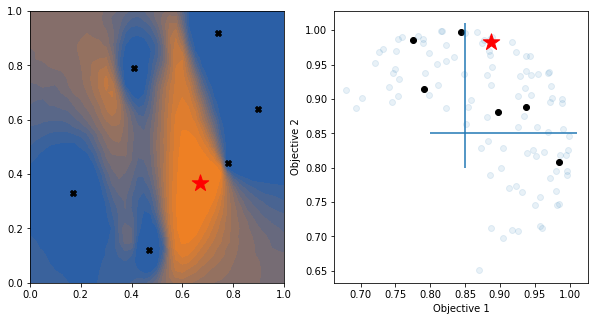

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].contourf(
  X, 
  Y, 
  numpy.reshape(emc_values, (mesh_shape)), 
  levels=numpy.linspace(numpy.min(emc_values), numpy.max(emc_values), 15), 
  cmap=cmap_sigopt,
  )
axes[0].scatter(initial_points[:, 0], initial_points[:, 1], marker='X', color='black')
axes[0].scatter(next_pt[0], next_pt[1], marker="*", color="red", s=300)

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].scatter(initial_ys[:, 0], initial_ys[:, 1], color="black")
axes[1].scatter(ys[:, 0], ys[:, 1], alpha=0.1)
axes[1].scatter(next_value[0], next_value[1], marker="*", color="red", s=300)
axes[1].vlines(lb[0], 0.8, 1.01)
axes[1].hlines(lb[1], 0.8, 1.01)

plt.show()
# fig.colorbar(cmap)



In [10]:
random_eval_points = domain.generate_quasi_random_points_in_domain(500)
random_emc_values = emc.evaluate_at_point_list(random_eval_points) 

high_emc_idx = random_emc_values >= 0.85
high_emc_points = random_eval_points[high_emc_idx]
high_emc_ys = numpy.zeros((len(high_emc_points), dim))
for i, pt in enumerate(high_emc_points):
  high_emc_ys[i] = two_humps_unscaled(pt)

In [11]:
numpy.percentile(random_emc_values, 90)

0.7650390625000003

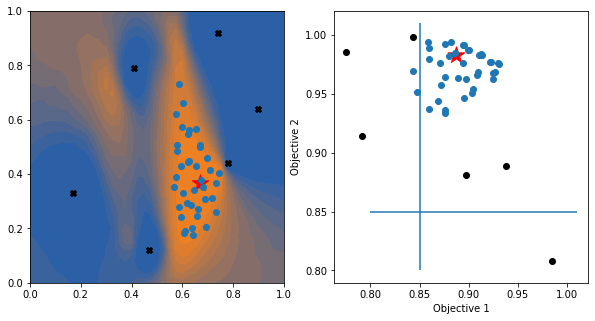

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].contourf(
  X, 
  Y, 
  numpy.reshape(emc_values, (mesh_shape)), 
  levels=numpy.linspace(numpy.min(emc_values), numpy.max(emc_values), 15), 
  cmap=cmap_sigopt,
  )
axes[0].scatter(initial_points[:, 0], initial_points[:, 1], marker='X', color='black')
axes[0].scatter(next_pt[0], next_pt[1], marker="*", color="red", s=300)
axes[0].scatter(high_emc_points[:, 0], high_emc_points[:, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].scatter(initial_ys[:, 0], initial_ys[:, 1], color="black")
# axes[1].scatter(ys[:, 0], ys[:, 1], alpha=0.1)
axes[1].scatter(next_value[0], next_value[1], marker="*", color="red", s=300)
axes[1].scatter(high_emc_ys[:, 0], high_emc_ys[:, 1])
axes[1].vlines(lb[0], 0.8, 1.01)
axes[1].hlines(lb[1], 0.8, 1.01)

plt.show()

[0.64258926 0.31646553]


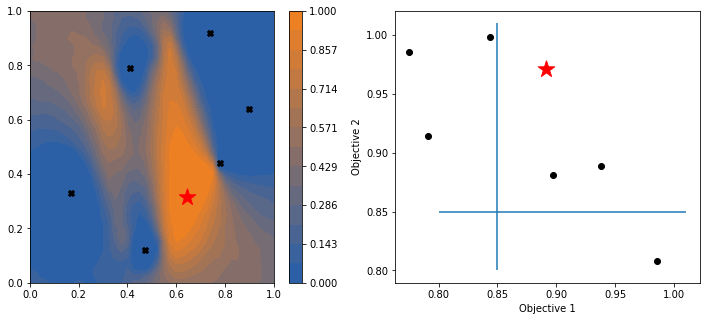

[0.54077411 0.24983435]


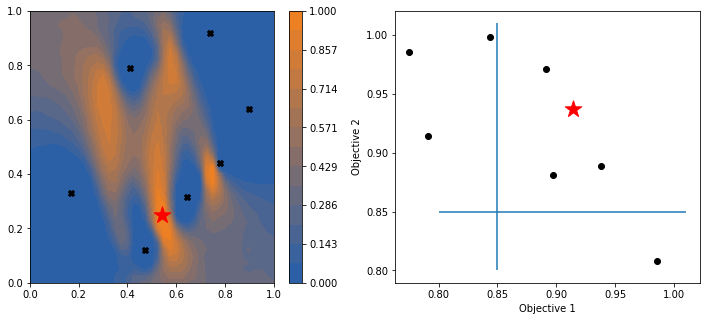

[0.75034457 0.40361332]


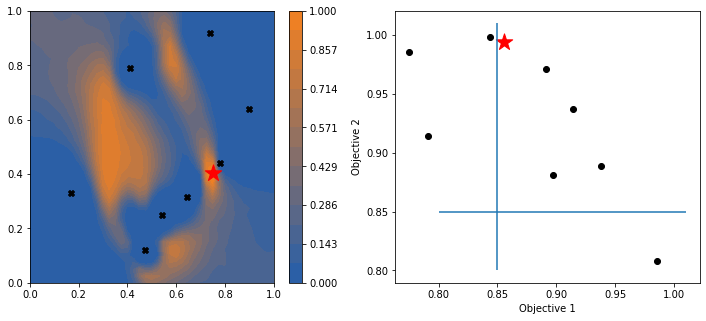

[0.32075959 0.44825888]


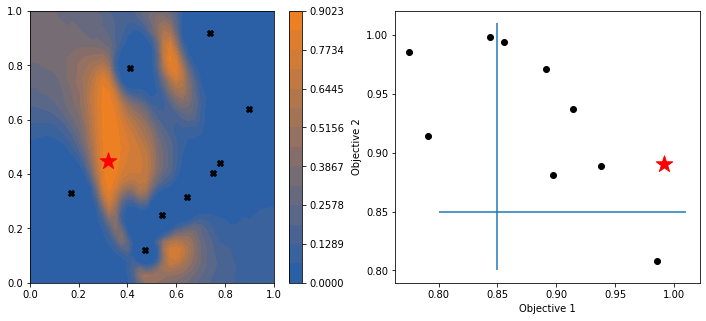

[0.44272816 0.42297223]


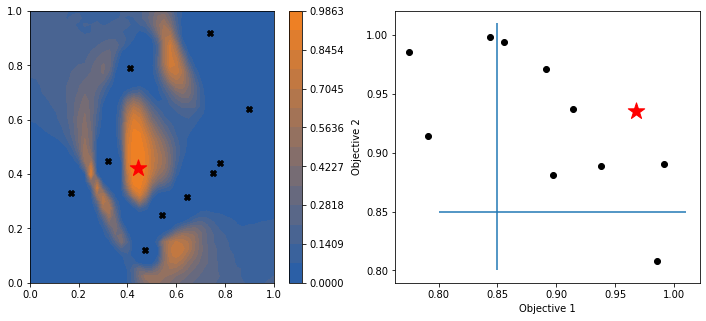

[0.59578922 0.1357087 ]


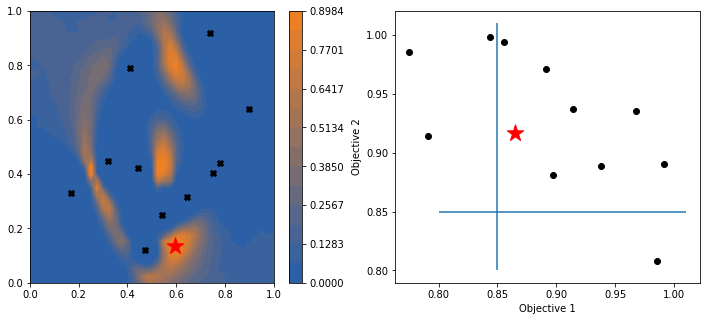

[0.53587993 0.41713506]


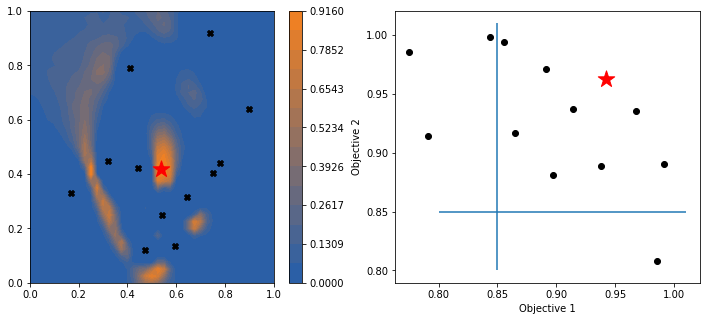

[0.67822405 0.21668889]


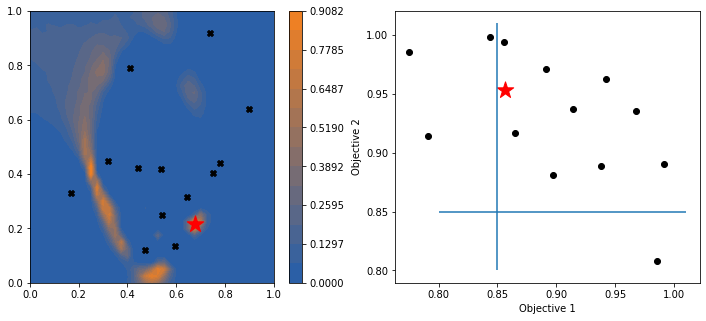

[0.26560484 0.36400823]


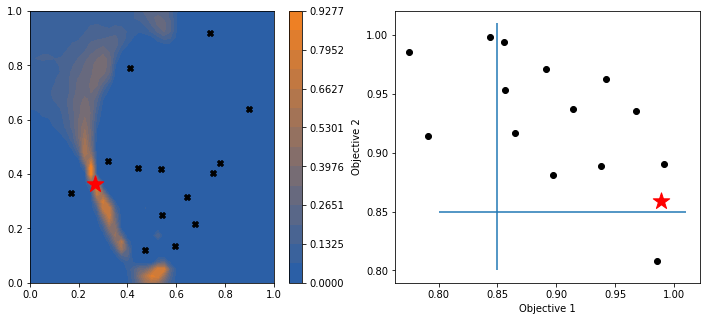

[0.52706701 0.04176211]


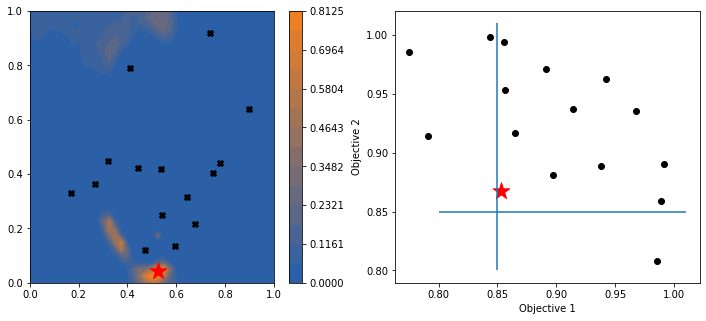

[0.37085163 0.13665114]


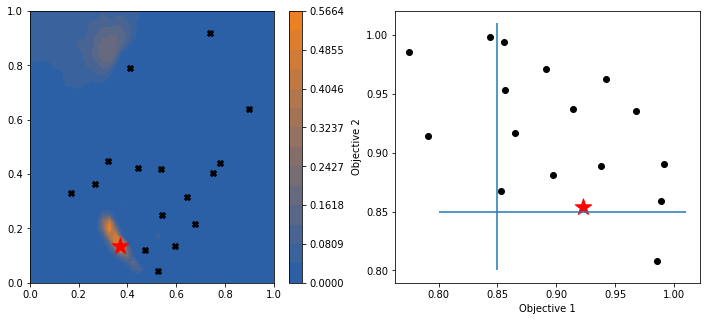

[0.33307942 0.21893659]


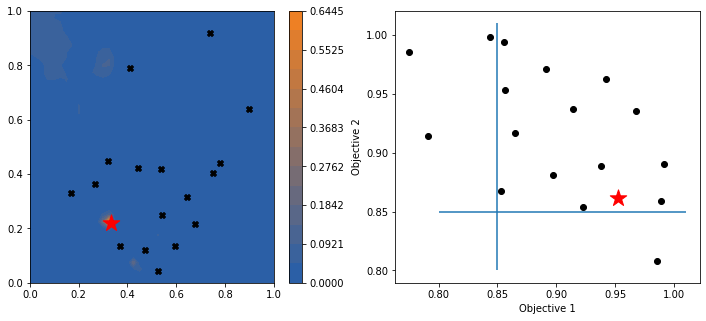

[0.43838452 0.06297948]


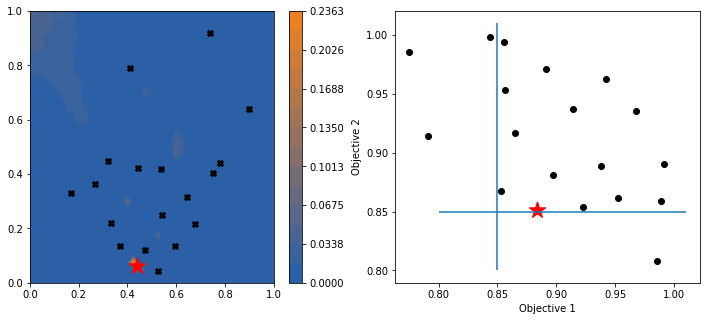

[0. 1.]


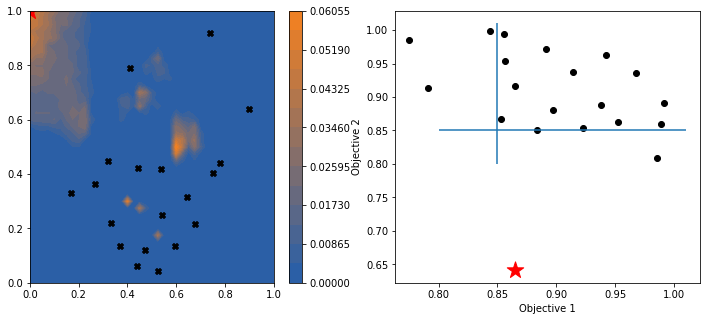

[0.61085683 0.47511172]


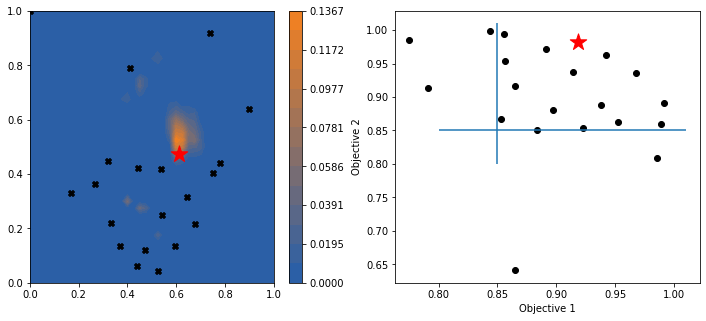

In [15]:
points_sampled = numpy.copy(initial_points)
points_sampled_values = numpy.copy(initial_ys)

budget = 15

for i in range(budget):
  gp = MultiOutputGP(points_sampled, points_sampled_values, train=False)
  gp.set_hypers([[0.01, 0.3, 0.3], [0.01, 0.3, 0.3]])
  emc = ExpectedMetricCoverage(gp, ub, lb, punchout_radius)
  de = DEOptimizer(domain, emc, 50)
  next_pt, _ = de.optimize()
  next_value = two_humps_unscaled(next_pt)
  print(next_pt)
  points_sampled = numpy.vstack((points_sampled, next_pt))
  points_sampled_values = numpy.vstack((points_sampled_values, next_value))
  
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  emc_values = emc.evaluate_at_point_list(grid_points)
  con = axes[0].contourf(
    X, 
    Y, 
    numpy.reshape(emc_values, (mesh_shape)), 
    levels=numpy.linspace(numpy.min(emc_values), numpy.max(emc_values), 15), 
    cmap=cmap_sigopt,
    )
  cbar = fig.colorbar(con, ax=axes[0])
  axes[0].scatter(points_sampled[:, 0], points_sampled[:, 1], marker='X', color='black')
  axes[0].scatter(next_pt[0], next_pt[1], marker="*", color="red", s=300)

  axes[1].set_xlabel('Objective 1')
  axes[1].set_ylabel('Objective 2')
  axes[1].scatter(points_sampled_values[:, 0], points_sampled_values[:, 1], color="black")
  # axes[1].scatter(ys[:, 0], ys[:, 1], alpha=0.1)
  axes[1].scatter(next_value[0], next_value[1], marker="*", color="red", s=300)
  axes[1].vlines(lb[0], 0.8, 1.01)
  axes[1].hlines(lb[1], 0.8, 1.01)

  plt.show()

In [13]:
def transmission(x):
  return .91 / (.65 - .22) * (
        (.4 + .5 * numpy.exp(-.001 * (x[0] - 5) ** 2)) *
        (.6 + .25 * numpy.exp(-.0005 * (x[1] - 40) ** 2)) *
        (.6 + .25 * numpy.exp(-.000005 * (x[2] - 100) ** 2)) - .22
    )

def emi_se(x):
  return 7.5 * numpy.log(x[0]) + 22

def cbotr_less_than_half_of_pitch(x):
  return 0.5 * x[2] - x[3]

def ctopr_less_than_cbotr(x):
  return x[3] - x[4]

def evaluate_all_metrics(x):
  m1 = emi_se(x)
  m2 = transmission(x)
  m3 = cbotr_less_than_half_of_pitch(x)
  m4 = ctopr_less_than_cbotr(x)
  return [m1, m2, m3, m4]

metric_names = [
  "EMI_SE",
  "Transmission",
  "0.5 pitch - cbotr",
  "cbotr - ctopr",
]

param_names = [
  "silvert",
  "bott",
  "pitch",
  "cbotr",
  "ctopr",
]

In [28]:
domain_components = [
  [1, 50],
  [10, 100],
  [40, 400],
  [20, 200],
  [10, 200],
]

thresholds = [40, 0.6, 0, 0]
domain = TensorProductDomain(domain_components)
random_points = domain.generate_quasi_random_points_in_domain(1000)
random_ys = numpy.zeros((len(random_points), 4))
for i, pt in enumerate(random_points):
  random_ys[i] = evaluate_all_metrics(pt)
  
satisfied = numpy.zeros(len(random_points), dtype=bool)
for i, y in enumerate(random_ys):
  satisfied[i] = numpy.all(y >= thresholds)

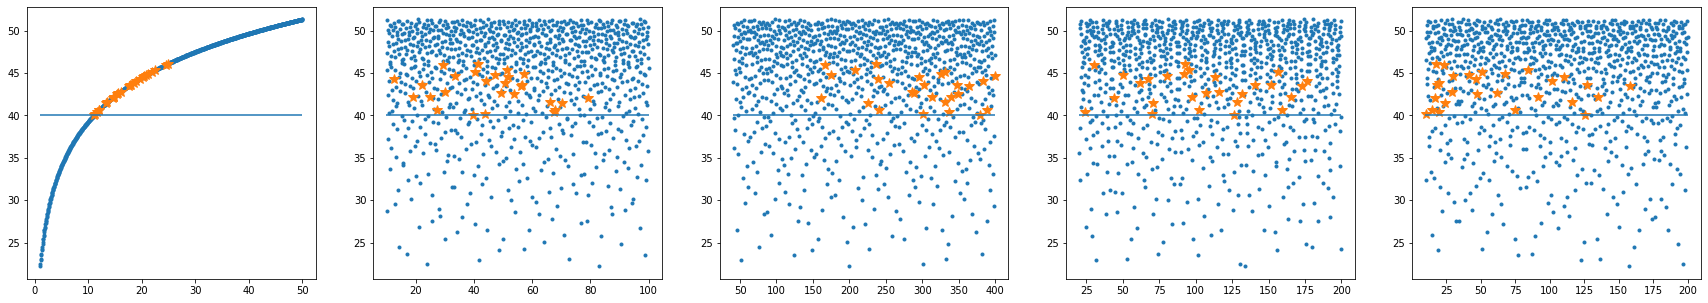

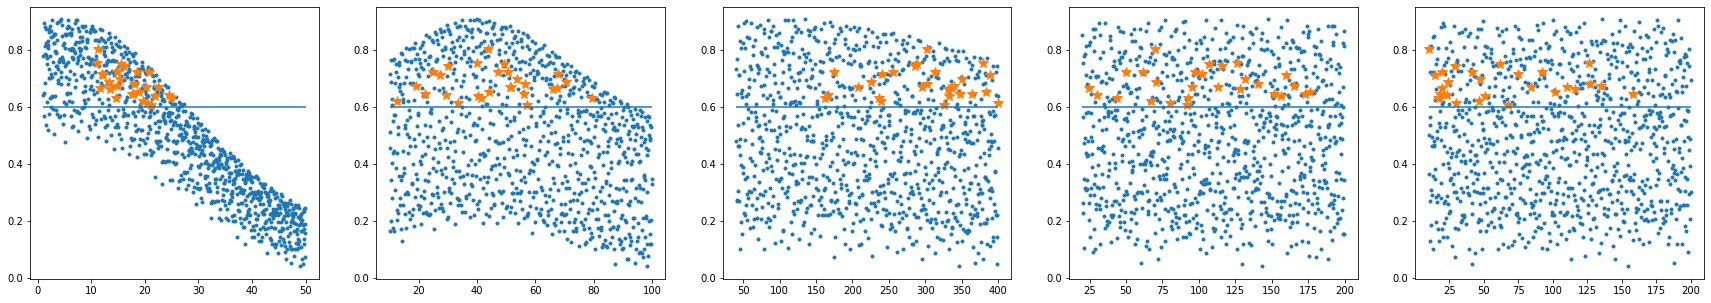

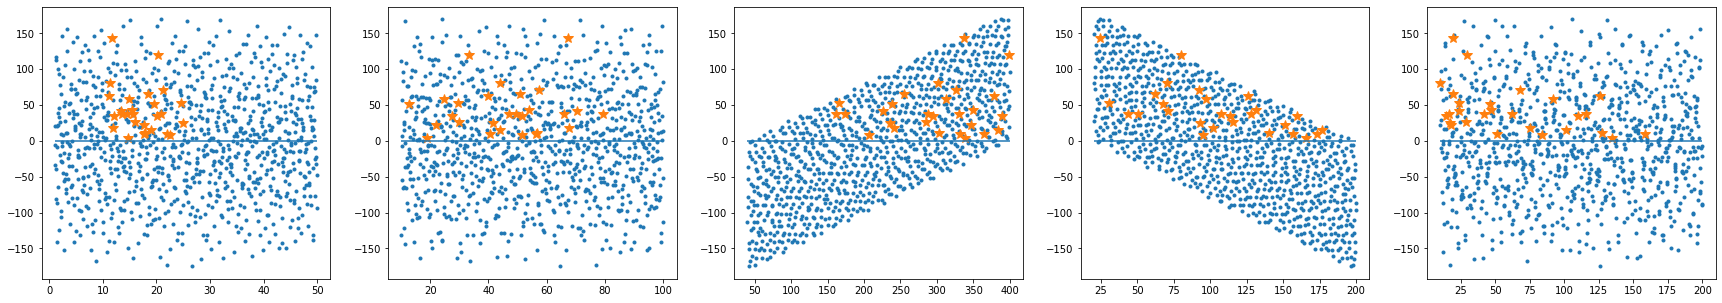

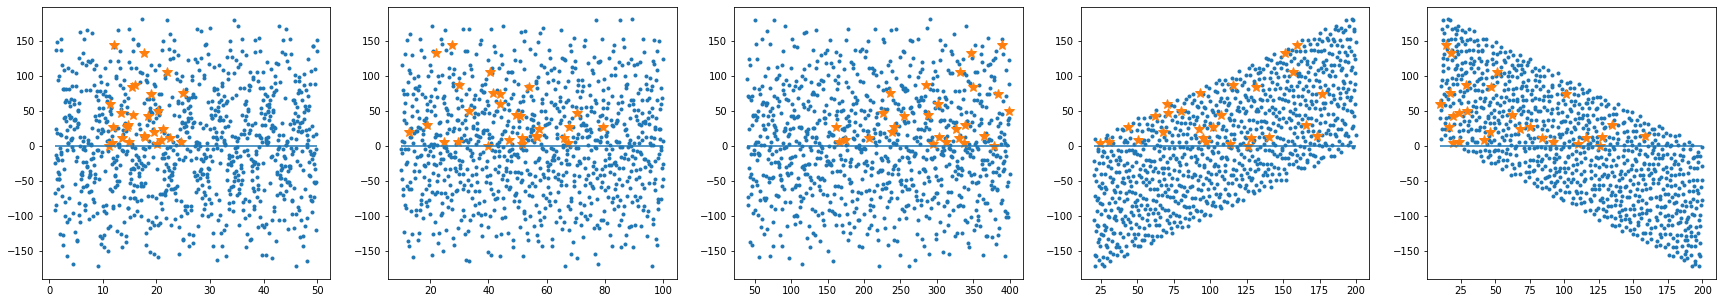

In [29]:
for i in range(4):
  fig, axes = plt.subplots(1, domain.dim, figsize=(6 * domain.dim, 5))
  for j, ax in enumerate(axes):
    ax.plot(random_points[:, j], random_ys[:, i], ".")
    ax.plot(random_points[satisfied, j], random_ys[satisfied, i], "*", markersize=10)
    ax.hlines(thresholds[i], domain.domain_bounds[j][0], domain.domain_bounds[j][1])


In [66]:
initial_points = domain.generate_quasi_random_points_in_domain(20 * domain.dim)
initial_ys = numpy.zeros((len(initial_points), 4))
for i, pt in enumerate(initial_points):
  initial_ys[i] = evaluate_all_metrics(pt)

In [67]:
gpm = MultiOutputGP(initial_points, initial_ys, train=True)
# gp.set_hypers([[10, 10, 30, 30, 50, 50]] * 4)
emc = ExpectedMetricCoverage(gpm, [1000] * 4, thresholds,  punchout_radius)


predicted_ys = gpm.predict(random_points)
predicted_satisfied = numpy.zeros(len(random_points), dtype=bool)
for i, y in enumerate(predicted_ys):
  predicted_satisfied[i] = numpy.all(y >= thresholds)

print("predicted satisfactory:", sum(predicted_satisfied))

random_ys = numpy.zeros((len(random_points), 4))
for i, pt in enumerate(random_points):
  random_ys[i] = evaluate_all_metrics(pt)
  
satisfied = numpy.zeros(len(random_points), dtype=bool)
for i, y in enumerate(random_ys):
  satisfied[i] = numpy.all(y >= thresholds)
print("actually satisfactory: ", sum(satisfied))
print("predicted correct", sum(numpy.logical_and(predicted_satisfied, satisfied)))


for gp in gpm.gaussian_processes:
  print(gp.ymean)
  print(gp.covariance.hyperparameters)

predicted satisfactory: 43
actually satisfactory:  37
predicted correct 37
44.363337487975635
[13.22454077  5.04951811 54.59815003 54.59815003 54.59815003 54.59815003]
0.4979837805281946
[1.33414768e-02 9.51719640e+00 2.18322244e+01 5.45981500e+01
 5.45981500e+01 5.45981500e+01]
-0.05669474462047219
[20.08553692 53.093653   54.59815003 54.59815003 28.86293491 54.59815003]
4.882038316642865
[20.08553692 54.59815003 54.59815003 54.59815003 28.19097031 27.82753366]


In [68]:
hypers = [
  [20, 5, 50, 50, 50, 50],
  [0.04, 0.67, 8.95, 0.29, 3.58, 0.74],
  [20, 54, 54, 25, 18, 54,],
  [20, 54, 54, 54, 30,  28,],
]

In [69]:
points_sampled = numpy.copy(initial_points)
points_sampled_values = numpy.copy(initial_ys)

budget = 50
punchout_radius = 1
satisfied = numpy.zeros(budget)
for i in range(budget):
  gp = MultiOutputGP(points_sampled, points_sampled_values, train=False)
  gp.set_hypers(hypers)
  emc = ExpectedMetricCoverage(gp, [10000] * 4, thresholds, punchout_radius)
  de = DEOptimizer(domain, emc, 100)
  next_pt, all_results = de.optimize()
  next_value = evaluate_all_metrics(next_pt)
  print(f"next points: {next_pt} | next value: {next_value}")
  print(numpy.max(all_results["function_values"]))
  print(f"satisfactory: {numpy.all(next_value > numpy.array(thresholds))}")
  satisfied[i] = numpy.all(next_value > numpy.array(thresholds))
  points_sampled = numpy.vstack((points_sampled, next_pt))
  points_sampled_values = numpy.vstack((points_sampled_values, next_value))
  
  random_points = domain.generate_quasi_random_points_in_domain(1000)
  predicted_ys = gpm.predict(random_points)
  predicted_satisfied = numpy.zeros(len(random_points), dtype=bool)
  for i, y in enumerate(predicted_ys):
    predicted_satisfied[i] = numpy.all(y >= thresholds)
  print("predicted satisfactory:", sum(predicted_satisfied))

  random_ys = numpy.zeros((len(random_points), 4))
  for i, pt in enumerate(random_points):
    random_ys[i] = evaluate_all_metrics(pt)

  satisfied = numpy.zeros(len(random_points), dtype=bool)
  for i, y in enumerate(random_ys):
    satisfied[i] = numpy.all(y >= thresholds)
  print("actually satisfactory: ", sum(satisfied))
  print("predicted correct", sum(numpy.logical_and(predicted_satisfied, satisfied)))


next points: [ 23.25128368  56.58729265 352.51706624 121.34442511  28.45293039] | next value: [45.59770257067255, 0.5605243483676957, 54.91410801373422, 92.8914947193116]
0.33984375
satisfactory: False
predicted satisfactory: 29
actually satisfactory:  29
predicted correct 25
next points: [ 45.3330197   57.719888   400.          91.31297347  63.99047238] | next value: [50.60526758976121, 0.18601075885936533, 108.68702653236687, 27.32250108709559]
0.35546875
satisfactory: False
predicted satisfactory: 28
actually satisfactory:  31
predicted correct 28
next points: [ 21.32822344  34.4179997  400.         126.33308486  10.        ] | next value: [44.950234297590484, 0.5991526177853562, 73.66691514384001, 116.33308485615999]
0.341796875
satisfactory: False
predicted satisfactory: 30
actually satisfactory:  26
predicted correct 25
next points: [ 21.92177518  39.03993996 400.         122.43996697  10.        ] | next value: [45.15610332550476, 0.5936481536612388, 77.56003302522004, 112.43996

next points: [ 26.84545247  30.59634083 216.54130448  65.51166703  10.        ] | next value: [46.67572329064962, 0.5858833294388699, 42.75898520741612, 55.511667034588754]
0.361328125
satisfactory: False
predicted satisfactory: 30
actually satisfactory:  29
predicted correct 26
next points: [ 19.90953095  43.92784545 400.         133.0736675   10.        ] | next value: [44.43398919495982, 0.6252516947655521, 66.92633249703795, 123.07366750296205]
0.572265625
satisfactory: True
predicted satisfactory: 34
actually satisfactory:  26
predicted correct 26
next points: [ 18.98190827  36.29223468 400.         119.26534298  10.        ] | next value: [44.07614747060205, 0.6403448433466005, 80.73465701859443, 109.26534298140557]
0.603515625
satisfactory: True
predicted satisfactory: 28
actually satisfactory:  28
predicted correct 24
next points: [ 19.41263158  32.73719768 400.         110.79481523  10.        ] | next value: [44.244429748884876, 0.6273177263499853, 89.2051847660914, 100.79481

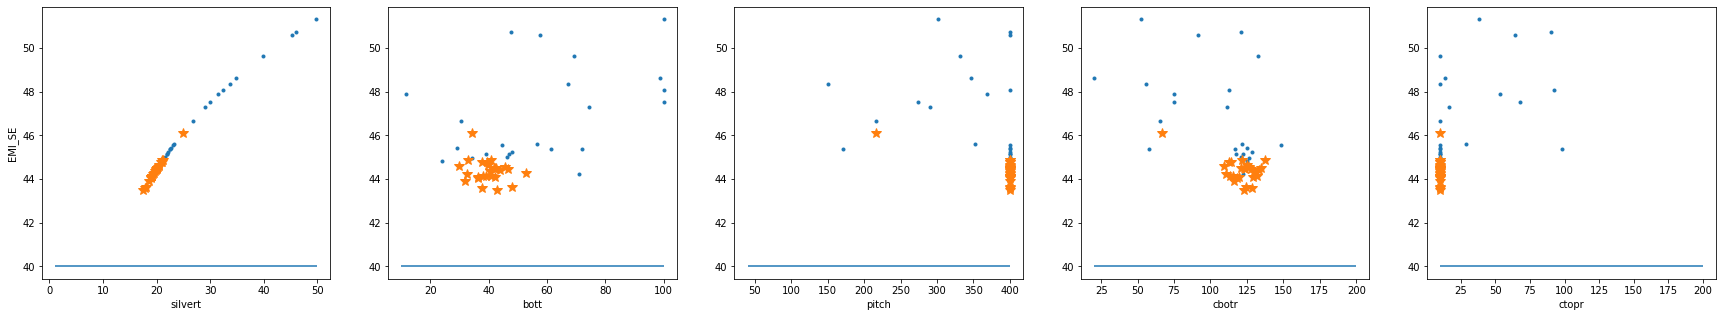

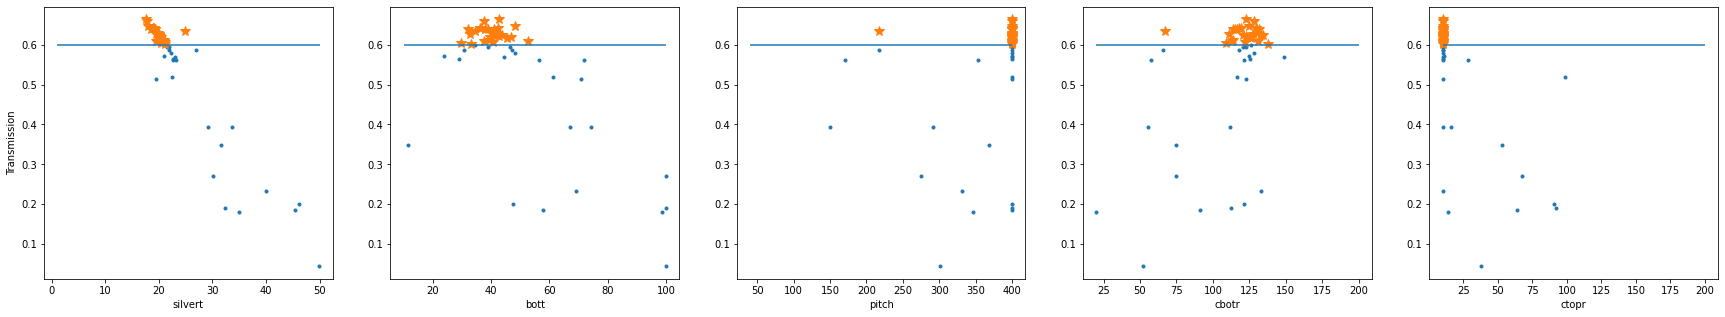

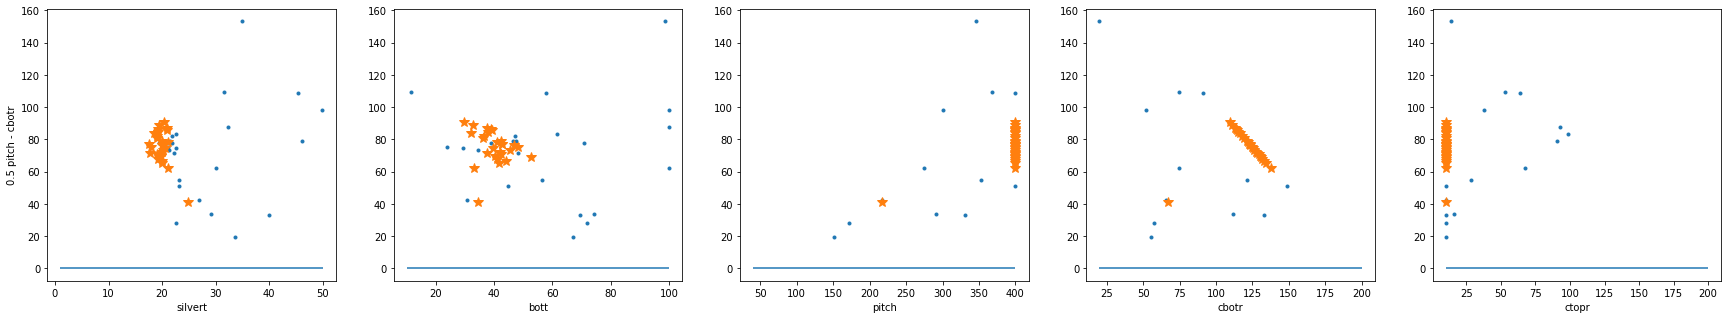

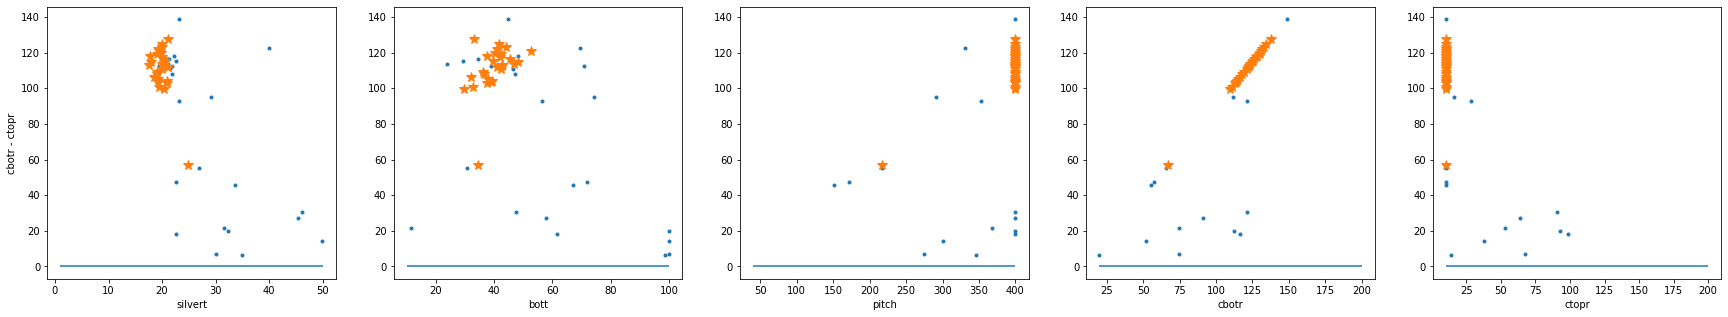

In [73]:
points_sampled_emc = points_sampled[len(initial_points):]
points_sampled_values_emc = points_sampled_values[len(initial_points):]
satisfied = numpy.zeros(len(points_sampled_emc), dtype=bool)
for i, y in enumerate(points_sampled_values_emc):
  satisfied[i] = numpy.all(y >= thresholds)
  
for i in range(4):
  fig, axes = plt.subplots(1, domain.dim, figsize=(6 * domain.dim, 5))
  for j, ax in enumerate(axes):
    ax.plot(points_sampled[len(initial_points):, j], points_sampled_values[len(initial_points):, i], ".")
    ax.plot(points_sampled_emc[satisfied.astype(bool), j], points_sampled_values_emc[satisfied.astype(bool), i], "*", markersize=10)
    ax.hlines(thresholds[i], domain.domain_bounds[j][0], domain.domain_bounds[j][1])
    ax.set_xlabel(param_names[j])
  axes[0].set_ylabel(metric_names[i])

In [74]:
points_sampled = numpy.copy(initial_points)
points_sampled_values = numpy.copy(initial_ys)

budget = 50
punchout_radius = 10
satisfied = numpy.zeros(budget)
for i in range(budget):
  gp = MultiOutputGP(points_sampled, points_sampled_values, train=False)
  gp.set_hypers(hypers)
  emc = ExpectedMetricCoverage(gp, [10000] * 4, thresholds, punchout_radius)
  de = DEOptimizer(domain, emc, 100)
  next_pt, all_results = de.optimize()
  next_value = evaluate_all_metrics(next_pt)
  print(f"next points: {next_pt} | next value: {next_value}")
  print(numpy.max(all_results["function_values"]))
  print(f"satisfactory: {numpy.all(next_value > numpy.array(thresholds))}")
  satisfied[i] = numpy.all(next_value > numpy.array(thresholds))
  points_sampled = numpy.vstack((points_sampled, next_pt))
  points_sampled_values = numpy.vstack((points_sampled_values, next_value))

next points: [ 41.63853794  62.30875063 400.         189.97890456 129.20708873] | next value: [49.96769598494738, 0.2122954801262693, 10.021095438860357, 60.771815828979015]
0.33203125
satisfactory: False
next points: [ 22.75198106  16.56827114 337.49744557  85.78870016  32.47198015] | next value: [45.4348916590756, 0.5427465022650837, 82.96002261992544, 53.31672001210973]
0.3515625
satisfactory: False
next points: [ 33.85293233  11.63490214 400.         111.60817173  44.48206706] | next value: [48.41519217104033, 0.29575866649010757, 88.39182826783508, 67.12610467430204]
0.3359375
satisfactory: False
next points: [ 17.56806904  44.02654195 389.59182121 124.08672517 105.70909151] | next value: [43.495622464270184, 0.6687528773047573, 70.70918543636799, 18.377633654046804]
0.32421875
satisfactory: True
next points: [ 44.1941868  100.         363.7979982  141.50602662  88.98929491] | next value: [50.414449450370256, 0.06939343478771995, 40.39297247584909, 52.51673171017319]
0.33203125
sa

next points: [ 48.06529713  91.11217148 400.         183.82760889  34.52463969] | next value: [51.04420332473224, 0.0476297267455181, 16.17239111233502, 149.30296919364483]
0.2421875
satisfactory: False
next points: [ 37.79929671  61.99614625 240.77569821  80.06933931  10.        ] | next value: [49.24217872618854, 0.3289361291393722, 40.31850980222225, 70.06933930516243]
0.23828125
satisfactory: False
next points: [ 50.          72.28287684 389.64636161  49.04037663  10.        ] | next value: [51.340172540711094, 0.09860196988796764, 145.78280417528003, 39.04037663154304]
0.23828125
satisfactory: False
next points: [ 50.          24.17206715 400.         183.7893498  171.79071037] | next value: [51.340172540711094, 0.1489504303704439, 16.210650195367634, 11.998639433644712]
0.234375
satisfactory: False
next points: [ 28.21021175  77.8591917  320.646185   148.02704345  64.3406671 ] | next value: [47.04763023518895, 0.37585410191493407, 12.296049043536186, 83.68637635931373]
0.23242187

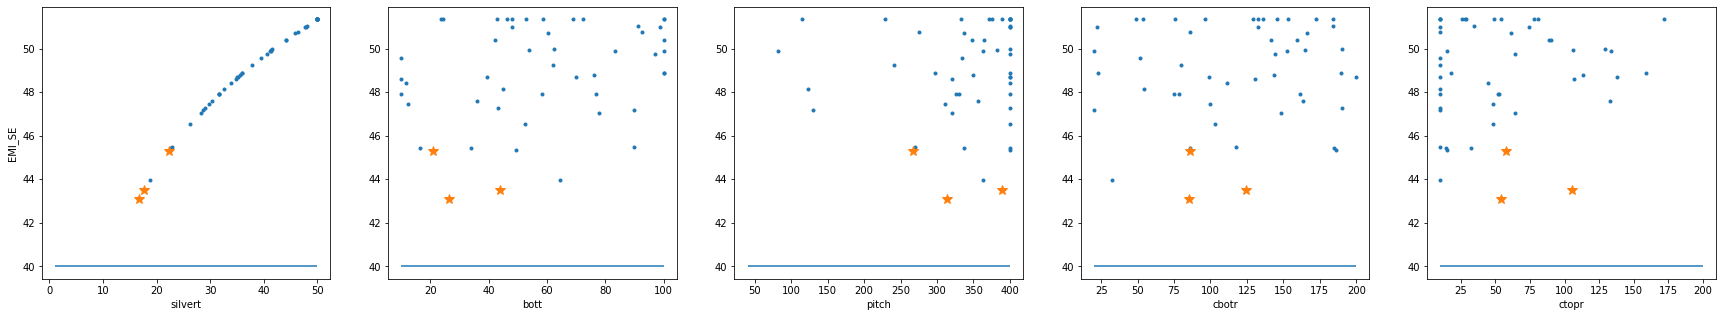

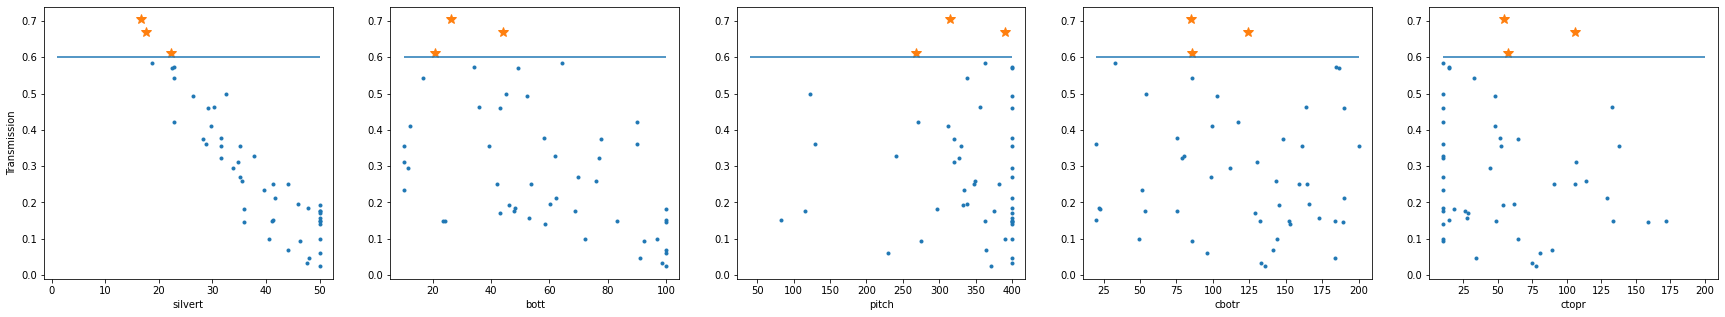

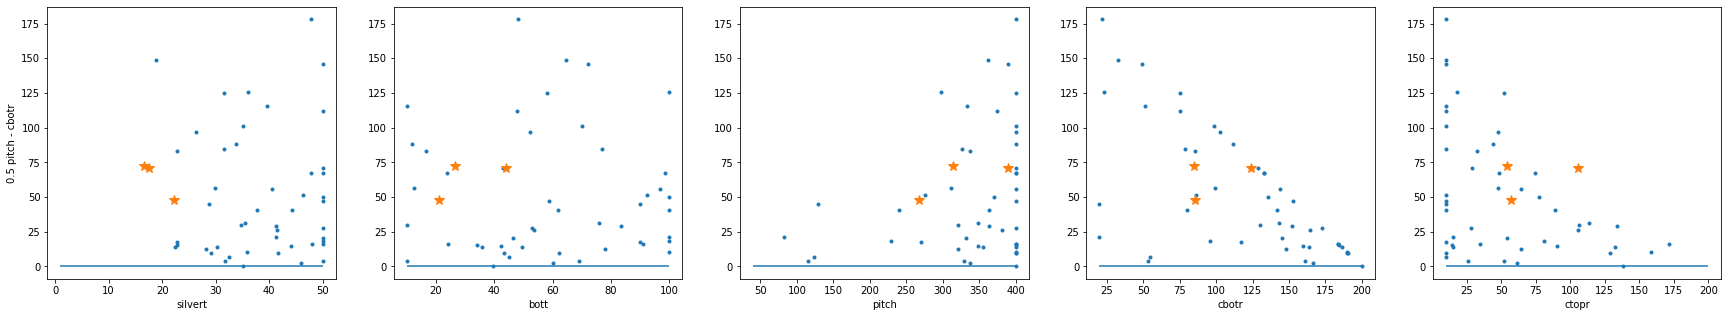

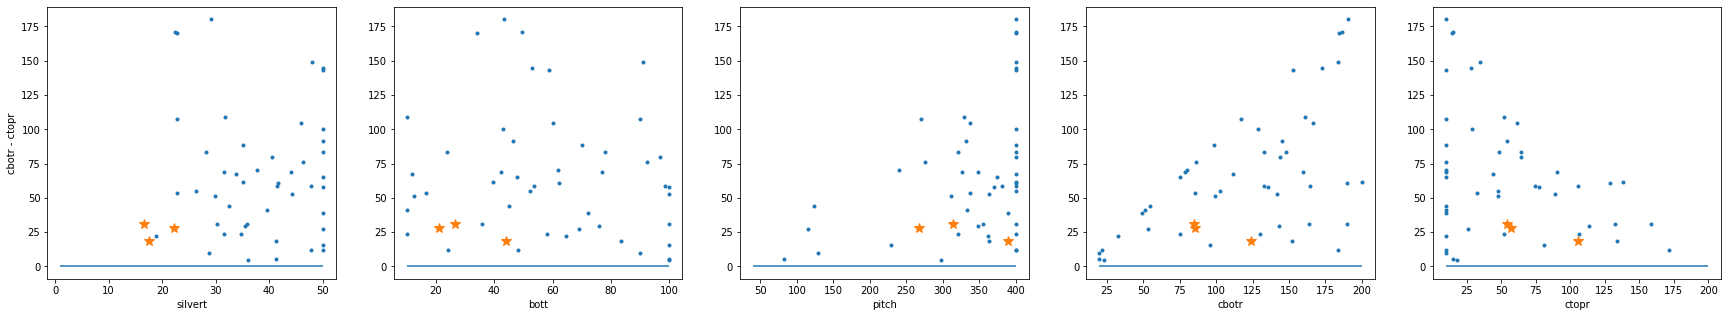

In [75]:
points_sampled_emc = points_sampled[len(initial_points):]
points_sampled_values_emc = points_sampled_values[len(initial_points):]
for i in range(4):
  fig, axes = plt.subplots(1, domain.dim, figsize=(6 * domain.dim, 5))
  for j, ax in enumerate(axes):
    ax.plot(points_sampled[len(initial_points):, j], points_sampled_values[len(initial_points):, i], ".")
    ax.plot(points_sampled_emc[satisfied.astype(bool), j], points_sampled_values_emc[satisfied.astype(bool), i], "*", markersize=10)
    ax.hlines(thresholds[i], domain.domain_bounds[j][0], domain.domain_bounds[j][1])
    ax.set_xlabel(param_names[j])
  axes[0].set_ylabel(metric_names[i])

In [76]:
sum(satisfied)

3.0